In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from Helper.ImportDatasetsFairness import df_epsilon, df_epsilon_crit, networks
from Helper.NonParametric import get_quantile, get_quantile_fairness


In [3]:
crit_epsilons_network = {}

for network in networks:
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_for_network = df_for_network.dropna() # Drop NaN values
    crit_epsilons_network[network] = df_for_network['Epsilon'].to_numpy()


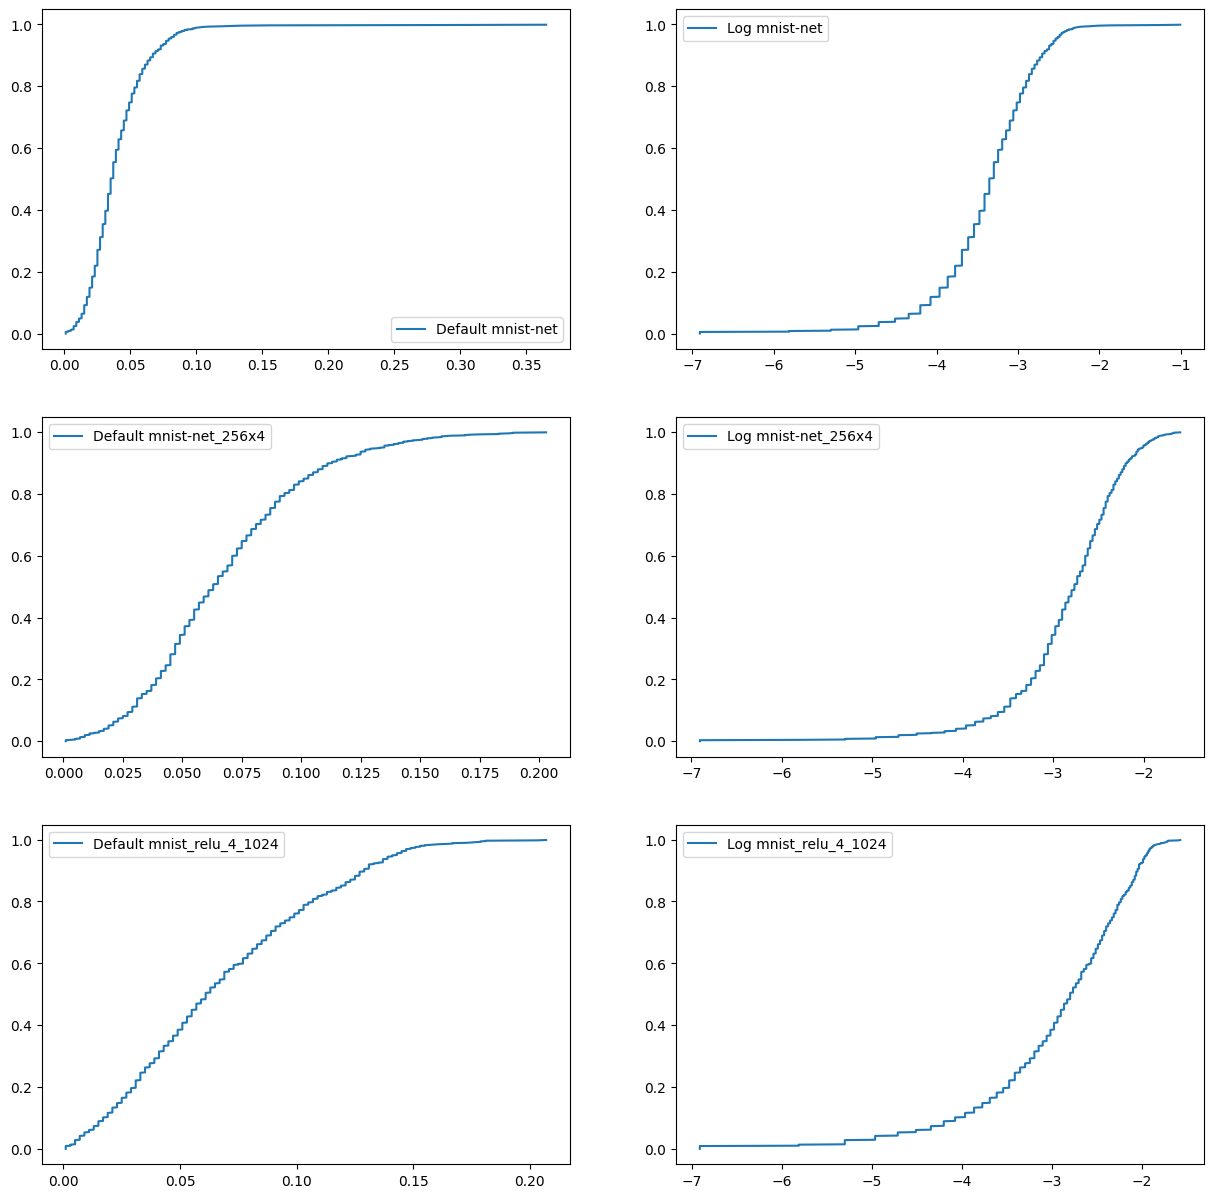

In [4]:
# Do this for all 3 networks so that the plots are on top of each other
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, network in enumerate(networks):
    x1 = np.sort(crit_epsilons_network[network])
    y1 = np.arange(len(x1))/float(len(x1))
    axs[i, 0].plot(x1, y1, label='Default ' + network)

    x2 = np.sort(np.log(crit_epsilons_network[network]))
    y2 = np.arange(len(x2))/float(len(x2))
    axs[i, 1].plot(x2, y2, label='Log ' + network)
    axs[i, 0].legend()
    axs[i, 1].legend()


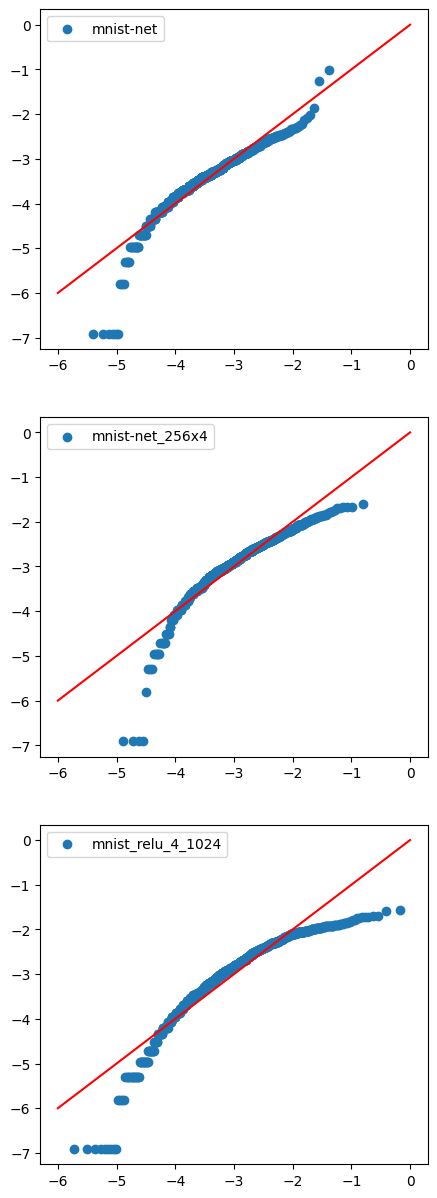

In [71]:
# QQ plots for all three networks
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i, network in enumerate(networks):
    # we are comparing to see if it is lognormal, so assuming this we transform it to normal
    random_samples = crit_epsilons_network[network]
    random_samples = np.sort(np.log(random_samples))

    # Generate the theoretical order statistics, we do this the quick and dirty way by generating them a lot of times then taking some average
    # parameters are fitted from the data in the standard way (MLE)
    simulated_samples = np.random.normal(np.mean(random_samples), np.std(random_samples), (len(random_samples), 10000))
    simulated_samples = np.sort(simulated_samples, axis=0)
    simulated_samples = np.median(simulated_samples, axis=1) # we take median as average

    axs[i].scatter(simulated_samples, random_samples, label=network)
    # plot diagonal line
    x = np.linspace(-6, 0, 100)
    axs[i].plot(x, x, color='red')
    axs[i].legend()
    
# save figure under folder Figures/QQ plots
fig.savefig('Figures/QQ plots/lognormal ' + network + '.png')

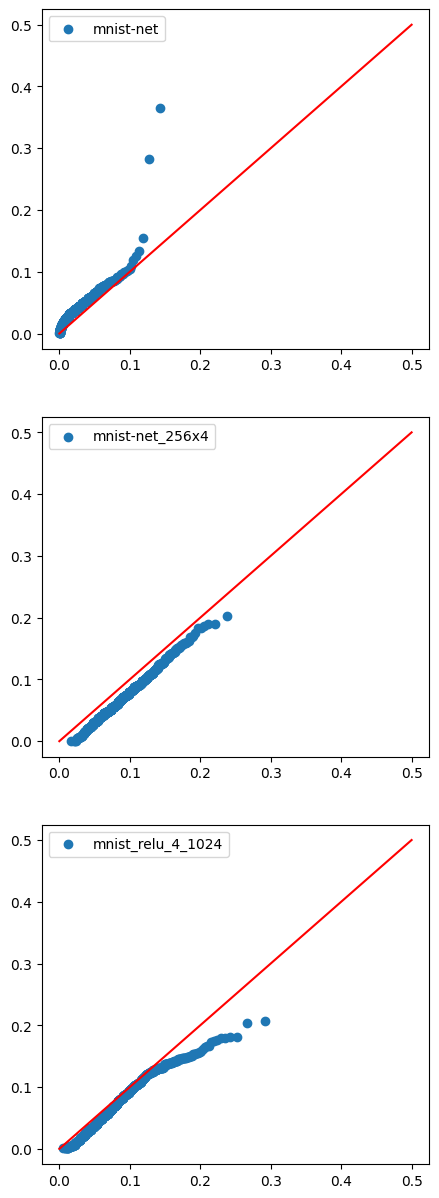

In [91]:
from scipy.stats import gamma
# Now lets try to fit a gamma distribution to the data
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i, network in enumerate(networks):
    y = crit_epsilons_network[network]
    y = np.sort(y)
    
    # generate the theoretical order statistics
    shape_estimated, loc_estimated, scale_estimated = gamma.fit(y)
    
    # the fit function isnt very good so i am manually adjusting the parameters
    if i == 0:
        shape_estimated = shape_estimated * 5
        scale_estimated = scale_estimated * 1/10
    
    x = np.random.gamma(shape_estimated, scale_estimated, (len(y), 10000))
    x = np.sort(x, axis=0)
    x = np.median(x, axis=1)
    
    axs[i].scatter(x,y, label=network)
    line = np.linspace(0, 0.5, 100)
    axs[i].plot(line, line, color='red')
    axs[i].legend()

# save figure under folder Figures/QQ plots
fig.savefig('Figures/QQ plots/gamma ' + network + '.png')

In [24]:
from scipy.stats import nct, norm

numbers = np.log(crit_epsilons_network[networks[0]])[00]
n = len(numbers)

# 95 ci for 0.05 quantile
mean = np.mean(numbers)
std = np.std(numbers, ddof=1)

noncentrality = -np.sqrt(n)*norm.ppf(0.05)
tl = nct.ppf(0.975, n-1, noncentrality)
t2 = nct.ppf(0.025, n-1, noncentrality)

ci = [np.exp(mean - tl*std/np.sqrt(n)), np.exp(mean - t2*std/np.sqrt(n))]


In [25]:
ci

[np.float64(0.007741843687297279), np.float64(0.010155184939148779)]

In [56]:
from scipy.special import comb

def binomial(n, p, x):
    '''
    :param n: number of trials
    :param p: probability of success, value of a (quantile)
    :param x: number of successes

    :return: probability of j successes
    '''

    return np.array([comb(n, xi, exact=True) for xi in x]) * (p ** x) * ((1 - p) ** (n - x))


def cdf_order_statistic_normal(index, n, x, mean, std):
    ps = norm.cdf(x, loc=mean, scale=std)
    j = np.arange(index, n+1) 
    cdf = np.sum(binomial(n, ps[:,None], j), axis=1)
    
    return cdf
    
    

In [61]:
samples = np.sort(np.random.normal(0, 1, 1000))
mean = np.mean(samples)
std = np.std(samples, ddof=1)
n = len(samples)
index = int(n*0.1)+1

x = np.linspace(-4, 4, 10000)

cdf = cdf_order_statistic_normal(index, n, x, mean, std)


-0.013208904257335917 1.002883984441148
-1.4029402940294027 -1.19011901190119


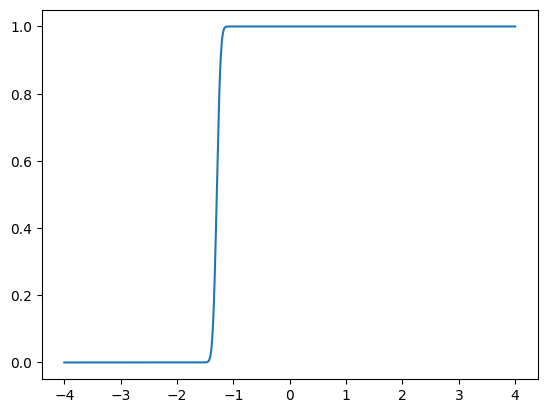

In [ ]:
alpha = 0.05
lower_index = np.where(cdf <= alpha / 2)[0][-1] # we want [ <= alpha/2 ][ >= 1-alpha ][ <= alpha/2 ]
upper_index = np.where(cdf >= 1 - alpha / 2)[0][0] # this way the confidence interval is at least 1-alpha

print(mean, std)
print(x[lower_index], x[upper_index])
plt.plot(x, cdf)

In [82]:
samples = np.log(crit_epsilons_network[networks[0]])[:500]
mean = np.mean(samples)
std = np.std(samples, ddof=1)
n = len(samples)
index = int(n*0.05)+1

x = np.linspace(np.min(samples), np.max(samples), 10000)

cdf = cdf_order_statistic_normal(index, n, x, mean, std)

-3.4312918496825433 0.6371318203092539
0.010132440190226487 0.012810727650533196
(np.float64(0.013), np.float64(0.009), np.float64(0.013))


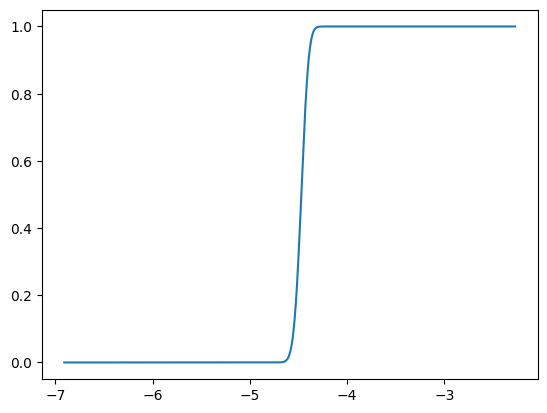

In [83]:
alpha = 0.05
lower_index = np.where(cdf <= alpha / 2)[0][-1] # we want [ <= alpha/2 ][ >= 1-alpha ][ <= alpha/2 ]
upper_index = np.where(cdf >= 1 - alpha / 2)[0][0] # this way the confidence interval is at least 1-alpha

print(mean, std)
print(np.exp(x[lower_index]), np.exp(x[upper_index]))
print(get_quantile_fairness(networks[0], 0.05))
plt.plot(x, cdf)

In [28]:
mean = np.mean(numbers)
std = np.std(numbers, ddof=1)

x = np.linspace(48, 55, 1000)
n = len(x)

index = int(0.90 * n) + 1

p = norm.cdf(x, loc=mean, scale=std)

cdf = p**n
y = np.cumsum(cdf)
lower_index = np.where(y <= 0.05 / 2)[0][-1] # we want [ <= alpha/2 ][ >= 1-alpha ][ <= alpha/2 ]
upper_index = np.where(y >= 1 - 0.05 / 2)[0][0] # this way the confidence interval is at least 1-alpha
print(x[lower_index], x[upper_index])

53.388388388388385 53.71771771771772


In [ ]:
# parametric Quantile distributions

def get_quantile(dat, sigma, verbose=False):
    '''
    :param dat: numpy array of data
    :param sigma: quantile

    :return: confidence interval for sigma quantile given the data
    '''

    n = len(dat)

    # We sort the critical epsilons
    order_statistics = np.sort(dat)
    # We use the order statistics to estimate the sigma quantile
    index = int(n * sigma) + 1  # As given by David et al. 2003 (Order Statistics)
    lower_index, upper_index = binomial_bounds(n, sigma, 0.05)
    
    if verbose:
        print(f"Indexes: {index}, {lower_index}, {upper_index}")
    
    return order_statistics[index], order_statistics[lower_index], order_statistics[upper_index]


In [ ]:
# split crit epsilon in things of 200 and then see the quantiles

for i in range(10):
    print(get_quantile(crit_epsilons[(i)*100:(i+1)*100], 0.05, verbose=True))

In [ ]:
get_quantile(crit_epsilons, 0.05)

In [ ]:
# sample a log normal 10000 times
log_normal = np.random.lognormal(0, 1, 10000000)

In [ ]:
# plot empirical cdf
x = np.sort(np.log(log_normal))
y = np.arange(len(x))/float(len(x))
plt.plot(x, y)
